In [1]:
%load_ext nb_black
%matplotlib inline
from IPython.display import set_matplotlib_formats
import matplotlib.pyplot as plt
import numpy as np
import logging
import jax

jax.config.update("jax_enable_x64", 1)

logging.getLogger().setLevel(logging.INFO)
set_matplotlib_formats("svg")


def plot_summary(ax, x, y, truth=None):
    q25, q50, q75 = np.quantile(y, [0.25, 0.5, 0.75], axis=0)
    assert len(set(x)) == 1
    x = x[0]
    ax.plot(x, q50, color="tab:blue")
    ax.fill_between(x, q25, q75, alpha=0.2, color="tab:blue")
    if truth is not None:
        x0 = np.arange(len(truth))
        ax.plot(x0, truth, "--", alpha=0.5, color="tab:grey")

<IPython.core.display.Javascript object>

In [2]:
from sim import sim_and_fit, sim_wf
from estimate import posterior_decoding
from common import Observation

<IPython.core.display.Javascript object>

## Various models

In [3]:
mdls = [
    {"s": [0.01] * 100, "h": [0.5] * 100, "f0": 0.1},
    {"s": [0.02] * 50 + [-0.02] * 50, "h": [0.5] * 100, "f0": 0.1},
    {"s": [0.02] * 100 + [0.0] * 50 + [-0.02] * 50, "h": [0.5] * 200, "f0": 0.1},
    {"s": (([0.02] * 40 + [-0.02] * 40) * 3)[:200], "h": [0.5] * 200, "f0": 0.5},
]

<IPython.core.display.Javascript object>

## Estimation

In [ ]:
%%time
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor
ctx = mp.get_context('spawn')
with ProcessPoolExecutor(4, mp_context=ctx) as p:
    futs = [[p.submit(sim_and_fit, m, seed=i, lam_=1e2) for i in range(10)] for m in mdls]
    res = [[f.result() for f in fs] for fs in futs]

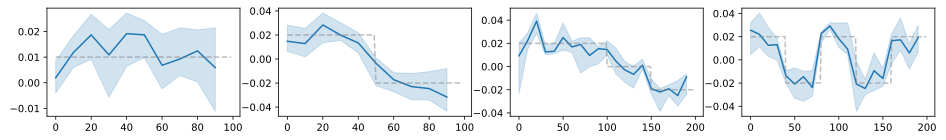

<IPython.core.display.Javascript object>

In [80]:
fig, axs = plt.subplots(ncols=4, figsize=(16, 2))
for r, ax, m in zip(res, axs, mdls):
    x, y = zip(*[(rr["t"][1:], -rr["s"]) for rr in r])
    plot_summary(ax, x, y, m["s"])

## Posterior decoding

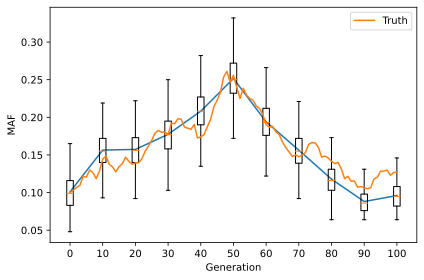

<IPython.core.display.Javascript object>

In [4]:
Ne = int(1e3)
rng = np.random.default_rng()
mdl = mdls[1]
af = sim_wf(Ne, mdl["s"], mdl["h"], mdl["f0"], rng)
n = 100
k = 10
obs = rng.binomial(n, af[::k])  # sample n haploids every d generations

data = [
    Observation(t=t, sample_size=n, num_derived=oo, Ne=Ne)
    for t, oo in zip(range(0, len(af), k), obs)
]

fig, ax = plt.subplots()
pd = posterior_decoding(
    data,  # observed data
    mdl["s"][::k],
    mdl["h"][::k],  # parameters for HMM
    64,  # number of discretizations
)
pd.draw(ax)
ax.plot(np.arange(len(af)), af, label="Truth")
ax.legend()
ax.set_xlabel("Generation")
ax.set_ylabel("MAF")
fig.tight_layout()

## Large $N_e$

In [ ]:
Ne = int(1e5)
rng = np.random.default_rng()
mdl = mdls[1]
af = sim_wf(Ne, mdl["s"], mdl["h"], mdl["f0"], rng)
n = 100
k = 10
obs = rng.binomial(n, af[::k])  # sample n haploids every d generations

data = [
    Observation(t=t, sample_size=n, num_derived=oo, Ne=Ne)
    for t, oo in zip(range(0, len(af), k), obs)
]

fig, ax = plt.subplots()
pd = posterior_decoding(
    data,  # observed data
    mdl["s"][::k],
    mdl["h"][::k],  # parameters for HMM
    64,  # number of discretizations
)
pd.draw(ax)
ax.plot(np.arange(len(af)), af, label="Truth")
ax.legend()
ax.set_xlabel("Generation")
ax.set_ylabel("MAF")
fig.tight_layout()

In [ ]:
## Debugging

In [ ]:
from hmm import trans, vf_sh
from common import Discretization

s = mdl["s"][0]
h = mdl["h"][0]
Ne = 1e8
disc1 = Discretization.factory(100, 100, Ne)
disc2 = disc1
T = trans(disc1, disc1, mdl["s"][0], mdl["h"][0])

In [ ]:
low1, mid1, high1, Ne1 = disc1
low2, mid2, high2, Ne2 = disc2

In [ ]:
import jax
import jax.numpy as jnp
from common import poisson_cdf, binom_pmf

mu_low = vf_sh(low1[1:, None] / Ne1, s, h)
T_11 = jax.scipy.stats.poisson.pmf(low2[None, :], mu_low)
# low -> medium
T_12 = jnp.diff(poisson_cdf(mid2[None, :], mu_low), axis=1)
# low -> high  (improbable unless Ne is tiny)
T_13 = jax.scipy.stats.poisson.pmf(high2[None, :], mu_low)

# Medium
mu_mid = vf_sh((mid1[:-1, None] + mid1[1:, None]) / 2 / Ne1, s, h)
sd_mid = jnp.sqrt(mu_mid * (1 - mu_mid) / Ne1)
# Medium -> low
T_21 = binom_pmf(low2[None, :], Ne2, mu_mid)
# Medium -> medium
T_22 = jnp.diff(jax.scipy.stats.norm.cdf(mid2[None, :] / Ne2, loc=mu_mid, scale=sd_mid))
T_23 = binom_pmf(high2[None, :], Ne2, mu_mid)

In [ ]:
plt.imshow(np.log(np.linalg.matrix_power(T, 10)))